# Introduction
We will predict a car's market price using its attributes using the k-nearest neighbors machine learning algorithm. We will be looking at the technical aspects of vehicles including the motor's displacement, car weight, miles per gallon, how fast the car accelerates, and more. We will be working with a dataset containing information on various cars, downloaded from: https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

# Reading, Cleaning, and Rescaling the Dataset
The dataset itself does not contain the headers described here: https://archive.ics.uci.edu/ml/datasets/automobile

In [453]:
# Column names to be written into the header as the dataset is read
column_names = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style',
                'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight',
                'engine_type', 'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
                'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']

import pandas as pd
cars = pd.read_csv('imports-85.data', names = column_names)
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


We want to work with columns that can be used as features, so the columns should be numeric and contain ordinal values. We also want to eventually drop columns or rows with null values. If we look at cars.info(), we may get the impression that there are no null values, despite the presence of, say, the question marks in normalized_losses. A few of the columns which are object types need to be converted to numerical values.

In [454]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized_losses    205 non-null object
make                 205 non-null object
fuel_type            205 non-null object
aspiration           205 non-null object
num_of_doors         205 non-null object
body_style           205 non-null object
drive_wheels         205 non-null object
engine_location      205 non-null object
wheel_base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb_weight          205 non-null int64
engine_type          205 non-null object
num_of_cylinders     205 non-null object
engine_size          205 non-null int64
fuel_system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression_ratio    205 non-null float64
horsepower           205 non-nul

Some of the columns that seem like good candidates for features are symboling (risk factor), normalized-losses, wheel_base, length, width, height, curb_weight, num_of_cylinders (convert words to numbers), engine_size, bore, stroke, compression_ratio, horsepower, peak_rpm, city_mpg, highway_mpg. Our target column is price.

In [455]:
# Drop columns pertaining to non-numeric values
drop_columns = ['make', 'fuel_type', 'aspiration', 'body_style', 'drive_wheels', 'engine_location', 
                'engine_type', 'fuel_system', 'num_of_doors']

cars = cars.drop(columns = drop_columns)

# Convert the words in num_of_cylinders to numbers
words_to_num = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}

cars['num_of_cylinders'] = cars['num_of_cylinders'].map(words_to_num)

column_names = cars.columns

cars.head()

,symboling,normalized_losses,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,88.6,168.8,64.1,48.8,2548,4,130,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,94.5,171.2,65.5,52.4,2823,6,152,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,99.8,176.6,66.2,54.3,2337,4,109,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,99.4,176.6,66.4,54.3,2824,5,136,3.19,3.40,8.0,115,5500,18,22,17450


Let us replace "?" with null, look for missing values, and rescale the values in the numeric columns. Let us also see which columns have "?" to begin with.

In [456]:
contain_question_mark = {}

for c in column_names:
    if cars[c].dtype == 'object':
        contain_question_mark[c] = cars[c].str.contains("?", regex = False).sum()
    
print(contain_question_mark)

{'normalized_losses': 41, 'bore': 4, 'stroke': 4, 'horsepower': 2, 'peak_rpm': 2, 'price': 4}


We have identified which columns contain "?", and which columns we need to convert to float.

In [457]:
import numpy as np

# Replace ? with np.nan
cars = cars.replace("?", np.nan)

# There are the columns that contain np.nan. See how many null values there are in each column
col_null = ['normalized_losses', 'bore', 'stroke', 'horsepower', 'peak_rpm', 'price']
num_null = {}

for c in col_null:
    cars[c] = cars[c].astype(float)
    num_null[c] = cars[c].isnull().sum()

print(num_null)

{'normalized_losses': 41, 'bore': 4, 'stroke': 4, 'horsepower': 2, 'peak_rpm': 2, 'price': 4}


Considering the normalized_losses column contains very many null values, let us drop the column entirely.

In [458]:
cars = cars.drop(columns = 'normalized_losses')

Let us remove the rows containing null values in the remaining columns in col_null.

In [459]:
cars = cars.dropna(axis = 0)
cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 204
Data columns (total 16 columns):
symboling            195 non-null int64
wheel_base           195 non-null float64
length               195 non-null float64
width                195 non-null float64
height               195 non-null float64
curb_weight          195 non-null int64
num_of_cylinders     195 non-null int64
engine_size          195 non-null int64
bore                 195 non-null float64
stroke               195 non-null float64
compression_ratio    195 non-null float64
horsepower           195 non-null float64
peak_rpm             195 non-null float64
city_mpg             195 non-null int64
highway_mpg          195 non-null int64
price                195 non-null float64
dtypes: float64(10), int64(6)
memory usage: 25.9 KB


By dropping null values, we have dropped one column and 10 data points.

Now, let us rescale the numeric columns that we have kept so that the values range from 0 to 1. We will create a new DataFrame in doing so.

In [460]:
# Keep prices column as non-normalized
normalized_cars = cars.copy()

for c in cars.columns:
    normalized_cars[c] = (cars[c] - cars[c].min()) / (cars[c].max() - cars[c].min())
    
normalized_cars['price'] = cars['price']
normalized_cars.head()

,symboling,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,1.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.111111,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,1.0,0.058309,0.413433,0.324786,0.083333,0.411171,0.111111,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.6,0.230321,0.449254,0.444444,0.383333,0.517843,0.333333,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.8,0.384840,0.529851,0.504274,0.541667,0.329325,0.111111,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.8,0.373178,0.529851,0.521368,0.541667,0.518231,0.222222,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


# Predicting Car Prices with the k-Nearest Neighbors Machine Learning Algorithm
# Train/Test Validation
### Univariate
We will be splitting the dataset into the training set and test set, as we will be employing the train/test validation process (75% to 25% split). Let us shuffle the dataset before making the split.

We will now use the k-nearest neighbors (k-NN) machine learning algorithm to predict car prices with our dataset. We will start with univariate models (one feature variable used to predict our prices) before building up to more complex models.

In [461]:
import math
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# knn_train_test encapsulates the training and validation process of the k-NN algorithm
# The function will split a shuffled normalized_cars dataset into the training and test sets
# The error metric will be the root mean squared error (RMSE)

def knn_train_test(training_features, target, df, k = 5):
    # For the sake of demonstration (such as showing off weaknesses of the training/test validation), we
    # will shuffle the dataset with a specific seed
    np.random.seed(1)
    shuffled_indices = np.random.permutation(df.index)
    df = df.reindex(shuffled_indices)
    
    # Divide the df DataFrame into roughly 75% to 25% (training and test)
    divider = math.floor(.75 * len(normalized_cars))    # Round down to the nearest integer
    training_df = df.iloc[0:divider]
    test_df = df.iloc[divider:]
    
    # Instantiate the k-NN model, then fit the model to the training set.
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(training_df[training_features], training_df[target])
    
    # Use trained model to predict the target on the test set
    prediction = knn.predict(test_df[training_features])
    
    # Calculate and return the rmse (compare with actual target values in the test set)
    rmse = mean_squared_error(test_df[target], prediction) ** .5
    
    return rmse

# Obtain the numerical features to be used in the knn_train_test function.
uni_features = list(normalized_cars.columns)
uni_features.remove('price')    # Exclude our target column
univariate_knn = {}    # Create empty dictionary to store our results

for c in uni_features:
    univariate_knn[c] = knn_train_test([c], 'price', normalized_cars)
    
rmse_results = pd.Series(univariate_knn).sort_values()
rmse_results

city_mpg             3552.957672
engine_size          3600.106720
length               3626.460507
wheel_base           3899.784039
width                4223.196157
horsepower           4418.784715
highway_mpg          4542.078598
curb_weight          4620.678681
num_of_cylinders     5006.991874
bore                 5517.116730
compression_ratio    6139.234683
height               6281.293614
stroke               6430.800062
peak_rpm             6864.166168
symboling            7415.585298
dtype: float64

We have predicted car prices on the test dataset using each numeric column as a feature in the univariate k-nearest neighbors machine learning model. From our model, it appears that the city_mpg column has performed the best, judging by how the corresponding root mean square error value was the lowest.

Let us now repeat this process by varying the hyperparameter, the number of neighbors k.

In [462]:
# The output from applying the k-NN model while varying k will be a dictionary of lists
hyperparam = np.array([1, 3, 5, 7, 9])
univariate_knn_vs_k = {}

for c in uni_features:
    univariate_knn_vs_k[c] = []
    
    for k in hyperparam:
        univariate_knn_vs_k[c].append(knn_train_test([c], 'price', normalized_cars, k))

# Create a DataFrame from this dictionary
uni_knn_vs_k_df = pd.DataFrame(univariate_knn_vs_k, index = hyperparam)
uni_knn_vs_k_df.index.name = 'Number of Neighbors'

uni_knn_vs_k_df

,symboling,wheel_base,length,width,height,curb_weight,num_of_cylinders,engine_size,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg
Number of Neighbors,,,,,,,,,,,,,,,
1,8123.823150,4227.711232,2786.243730,3349.996293,8412.705263,4418.963700,6671.301126,2579.307153,4434.610470,11479.750246,7029.901573,3101.559252,5771.157923,3906.911124,5561.001167
3,6410.943385,2720.826870,3414.031252,3510.359210,7317.426987,5098.875161,5984.203447,3159.057015,4347.041905,5708.139207,6222.449579,4250.711438,7297.807034,3820.177842,4947.069408
5,7415.585298,3899.784039,3626.460507,4223.196157,6281.293614,4620.678681,5006.991874,3600.106720,5517.116730,6430.800062,6139.234683,4418.784715,6864.166168,3552.957672,4542.078598
7,6792.411514,3895.499583,4027.988208,4180.346133,6211.583948,4356.714056,5348.536964,3834.393587,5964.023231,6677.060922,5909.729862,4832.215138,6604.182379,3995.215673,4353.056876
9,6648.648635,4030.968596,4095.729866,4207.612213,6210.532484,4017.642766,5478.107578,3316.257426,6430.935084,7432.581625,6542.129318,4608.411912,6470.314667,3949.606141,4158.997358


Let us visualize our results by plotting the root mean square errors of the features against the hyperparameter.

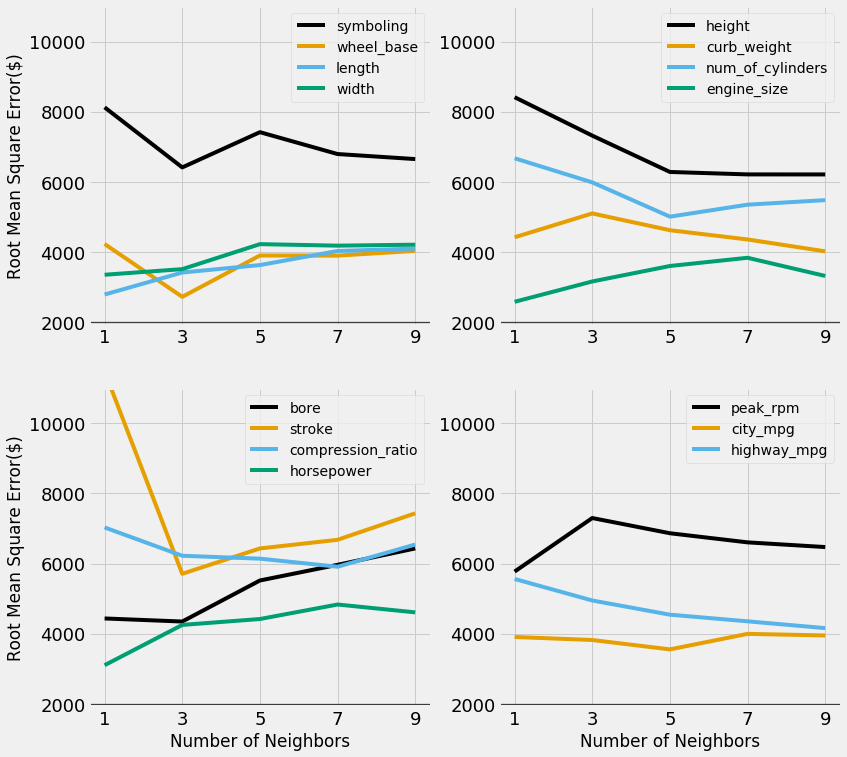

In [495]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

style.use('fivethirtyeight')
fig = plt.figure(figsize = (12, 12))

# Colorblind-friendly colors
colors = [[0,0,0], [230/255,159/255,0], [86/255,180/255,233/255], [0,158/255,115/255], 
          [213/255,94/255,0], [0,114/255,178/255]]

for i in range(4):
    if i != 3:
        ax = fig.add_subplot(2,2,(i+1))
        knn_k_plot = uni_knn_vs_k_df.reset_index().plot(x = 'Number of Neighbors',
                                                        y = uni_features[(4*i):(4*i + 4)],
                                                        ax = ax, color = colors)
    else:
        ax = fig.add_subplot(224)
        knn_k_plot = uni_knn_vs_k_df.reset_index().plot(x = 'Number of Neighbors',
                                                        y = uni_features[12:15], 
                                                        ax = ax, color = colors)
    
    knn_k_plot.set_xticks([1, 3, 5, 7, 9])
    knn_k_plot.axhline(2000, color = 'black', linewidth = 1.3, alpha = 0.7)
    knn_k_plot.set_ylim([1930, 11000])
    knn_k_plot.tick_params(labelsize = 18)
    
    if i == 0 or i == 1:
        knn_k_plot.xaxis.label.set_visible(False)
    if i % 2 == 0:
        knn_k_plot.set_ylabel('Root Mean Square Error($)')

In the meantime, let us look at the minimum values in each column (feature) to see the rmse minima.

In [464]:
rmse_vs_k_results = uni_knn_vs_k_df.min().sort_values()
rmse_vs_k_results

engine_size          2579.307153
wheel_base           2720.826870
length               2786.243730
horsepower           3101.559252
width                3349.996293
city_mpg             3552.957672
curb_weight          4017.642766
highway_mpg          4158.997358
bore                 4347.041905
num_of_cylinders     5006.991874
stroke               5708.139207
peak_rpm             5771.157923
compression_ratio    5909.729862
height               6210.532484
symboling            6410.943385
dtype: float64

It appears that the engine_size feature has had the best performance in the k-nearest neighbors algorithm. If we look at the plot, the engine_size feature performs best when the number of neighbors is 1. 

From these results, the five best features are engine_size, wheel_base, length, horsepower, and width. This suggests that the car's dimensions and performance are metrics that have the most influence in the determination of a car's value, or price.

We can try reducing the error by increasing the complexity by introducing more features in a k-NN fit. This may improve the performance of the k-NN model for a higher value of k.

## Multivariate

We will be training a multivariate k-NN model on our dataset and using that to predict car prices. For now, we will use the default k value (number of neighbors), as specified by KNeighborsRegression. Our validation process will still be the train/test validation process.

Let us begin by using all numerical features at once in the k-NN model and see how the model performs.

In [465]:
# Pass into the k-NN model the list uni_features, as this is a list of all of the numerical features in the dataset
all_features_rmse = knn_train_test(uni_features, 'price', normalized_cars)
all_features_rmse

3879.9558575229344

By passing in every numerical feature in the k-NN model, we have minimized our bias, but maximized our variance, which is another source of error. As a result, our root mean square error is actually higher than some values of the rmse when we used a univariate k-NN model for 5 neighbors.

In [466]:
all_features_rmse < rmse_vs_k_results

engine_size          False
wheel_base           False
length               False
horsepower           False
width                False
city_mpg             False
curb_weight           True
highway_mpg           True
bore                  True
num_of_cylinders      True
stroke                True
peak_rpm              True
compression_ratio     True
height                True
symboling             True
dtype: bool

We want to test our a multivariate k-nearest neighbors model to predict car prices, but we do not want to make the model overly complex so that we introduce too much variance. Let us, then, start by passing in two features into the k-NN model and gauge its performance. We will be introducing the two features with the best performance when we ran the univariate k-NN model against multiple k values: engine_size and wheel_base.

In [467]:
# Pass into the k-NN model city_mpg and engine_size, the features which performed the best in univariate k-NN
two_features_rmse = knn_train_test(['engine_size', 'wheel_base'], 'price', normalized_cars)
two_features_rmse

2995.2432056887287

It appears that with five neighbors, the k-NN model with two features passed in performs significantly better than the univariate k-NN model.

In [468]:
two_features_rmse < rmse_results

city_mpg             True
engine_size          True
length               True
wheel_base           True
width                True
horsepower           True
highway_mpg          True
curb_weight          True
num_of_cylinders     True
bore                 True
compression_ratio    True
height               True
stroke               True
peak_rpm             True
symboling            True
dtype: bool

Let us further reduce the model's bias by passing in our three best features into the k-NN model.

In [469]:
# Three best features from univariate k-NN: city_mpg, engine_size, length
three_features_rmse = knn_train_test(['engine_size', 'wheel_base', 'length'], 'price', normalized_cars)
print(three_features_rmse)
print('Does the k-NN model have better performance with three features than with two features? ', 
      three_features_rmse < two_features_rmse)

2995.0252922512177
Does the k-NN model have better performance with three features than with two features?  True


There is a marginal improvement in the model's performance with three features over the model with two features. Let us continue reducing the bias and increasing the complexity with four features.

In [470]:
# Four best features from univariate k-NN: city_mpg, engine_size, length, wheel_base
four_features_rmse = knn_train_test(['engine_size', 'wheel_base', 'length', 'horsepower'],
                                    'price', normalized_cars)

print(four_features_rmse)
print('Does the k-NN model have better performance with four features than with three features? ', 
      four_features_rmse < three_features_rmse)

3292.83652612077
Does the k-NN model have better performance with four features than with three features?  False


The root mean square error has gone back up with the introduction of a fourth feature passed into the k-NN model in comparison to the k-NN model with three features. To see if this is a trend or an anomaly, let us pass five features into the k-NN model.

In [471]:
# Five best features from univariate k-NN: city_mpg, engine_size, length, wheel_base, width
five_features_rmse = knn_train_test(['engine_size', 'wheel_base', 'length', 'horsepower', 'width'],
                                    'price', normalized_cars)

print(five_features_rmse)
print('Does the k-NN model have better performance with five features than with four features? ', 
      five_features_rmse < four_features_rmse)

2858.5036857825903
Does the k-NN model have better performance with five features than with four features?  True


It appears that the multivariate k-NN model's performance has improved with a fifth feature. In fact, this is currently our lowest value for the RMSE for five neighbors.

We have obtained the lowest root mean squared errors from multivariate k-NN models trained with five features (the best), three features (second best), and two features (third best). We will be further testing the multivariate models with these number of features by varying the hyperparameter.

### Improving Our Multivariate Models by Varying the Hyperparameter

In [472]:
# Vary the hyperparameter, the number of neighbors, from 1 to 25
hyperparam = range(1, 26)

# Store results in a DataFrame, which will be plotted
hyperparam_vs_features = pd.DataFrame([])
hyperparam_vs_features['Hyperparameter'] = hyperparam

two_feature_rmse_vs_k = []
# Two features
for k in hyperparam:
    two_feature_rmse_vs_k.append(knn_train_test(['engine_size', 'wheel_base'], 'price', normalized_cars, k))

hyperparam_vs_features['Two Features'] = two_feature_rmse_vs_k    

print('The minimum RMSE for two features is', hyperparam_vs_features['Two Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features['Two Features'].values.argmin()])

The minimum RMSE for two features is 2809.2183191460663 at k = 3


In [473]:
three_feature_rmse_vs_k = []
# Three features
for k in hyperparam:
    three_feature_rmse_vs_k.append(knn_train_test(['engine_size', 'wheel_base', 'length'], 
                                                 'price', normalized_cars, k))
    
hyperparam_vs_features['Three Features'] = three_feature_rmse_vs_k    

print('The minimum RMSE for three features is', hyperparam_vs_features['Three Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features['Three Features'].values.argmin()])

The minimum RMSE for three features is 2748.5600119027076 at k = 4


In [474]:
five_feature_rmse_vs_k = []
# Five features
for k in hyperparam:
    five_feature_rmse_vs_k.append(knn_train_test(['engine_size', 'wheel_base', 'length', 'horsepower', 'width'], 
                                                 'price', normalized_cars, k))
    
hyperparam_vs_features['Five Features'] = five_feature_rmse_vs_k    

print('The minimum RMSE for five features is', hyperparam_vs_features['Five Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features['Five Features'].values.argmin()])

The minimum RMSE for five features is 1850.0757017054239 at k = 1


Text(2.5,2750,'Five Features')

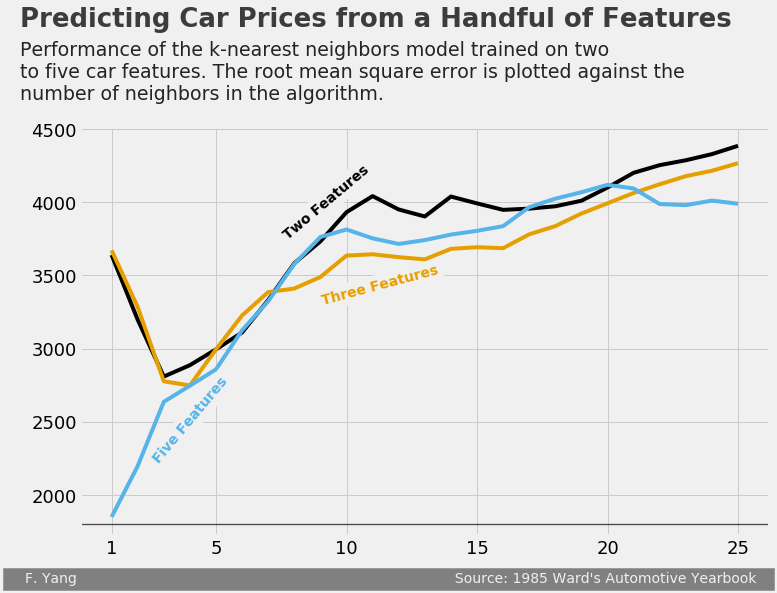

In [517]:
hvf_graph = hyperparam_vs_features.plot(x = 'Hyperparameter', y = hyperparam_vs_features.columns[1:], 
                                        figsize = (11, 7), color = colors, legend = False)

hvf_graph.axhline(1800, color = 'black', linewidth = 1.3, alpha = 0.7)

hvf_graph.xaxis.label.set_visible(False)            # Remove x-axis label
hvf_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
hvf_graph.set_xticks([1, 5, 10, 15, 20, 25])
hvf_graph.set_xticklabels(labels = [1, 5, 10, 15, 20, 25])

# Add signature bar
hvf_graph.text(x = -3, y = 1400,
               s = "    F. Yang                                                                                    Source: 1985 Ward's Automotive Yearbook   ",
               fontsize = 14, 
               color = '#f0f0f0', backgroundcolor = 'grey')

# Add title and subtitle
hvf_graph.text(x = -2.5, y = 5200, s = 'Predicting Car Prices from a Handful of Features',
               fontsize = 26, weight = 'bold', alpha = .75)
hvf_graph.text(x = -2.5, y = 4700, s = 'Performance of the k-nearest neighbors model trained on two \nto five car features. The root mean square error is plotted against the\nnumber of neighbors in the algorithm.',
               fontsize = 19, alpha = .85)

# Add colored labels
hvf_graph.text(x = 7.5, y = 4200, s = 'Two Features', color = colors[0], weight = 'bold', rotation = 40,
               backgroundcolor = '#f0f0f0')
hvf_graph.text(x = 9, y = 3510, s = 'Three Features', color = colors[1], weight = 'bold', rotation = 15,
               backgroundcolor = '#f0f0f0')
hvf_graph.text(x = 2.5, y = 2750, s = 'Five Features', color = colors[2], weight = 'bold', rotation = 50,
               backgroundcolor = '#f0f0f0')

It is observed that by introducing more neighbors to the k-nearest neighbors model (i.e. increasing the hyperparameter), the variance is increased to the point where the root mean square error increases and tapers off to  4000-4500, regardless of the number of features. 

When two features are passed into the model, the optimal k value is 3. When three features are passed into the model, the optimal k value is 4. When five features are passed into the model, the optimal number of nearest neighbors is 1, indicating that the predicted price for a given car is exactly the same as the car with the most similar five features (horsepower, engine size, wheel base, and dimensions).

When more features of a car are considered, it appears to be prudent to make more specific comparisons (i.e. make comparisons to fewer cars that are the most similar) in order to evaluate a car's price. With few features, like two, comparisons between cars can be rather vague and up in the air so that you would need to consider a handful of cars in order to make an evaluation of a car's price.

Up until now, we have used the train/test validation process to evaluate the performance of our k-nearest neighbors model. The problem with this method was that our model has been biased towards a specific subset of data. We can reduce this bias by running the train/test validation process many times (like 50 or more) and averaging the error metric, but that will be a computationally expensive process. Alternatively, we can change our validation process to a more robust technique that shows less bias, k-fold cross-validation.

## K-Fold Cross-Validation

We will repeat our procedure in the train/test validation process, modifying the knn_train_test function so that we instead use the k-fold cross-validation technique, where:
- The normalized_cars dataset is split into *n* partitions
- *n*-1 of the partitions will make up the training set, and the remaining partition will be the test set
- The model will be trained, predict labels on the test fold, and we will obtain an error metric
- This process is repeated *n*-1 more times until each partition has been used as a test set
- The final error metric is the mean of the *n* error values

In [490]:
# knn_cross_validation encapsulates the k-fold cross-validation process of the k-NN algorithm
from sklearn.model_selection import KFold, cross_val_score

def knn_cross_validation(training_features, target, df, k = 5, n_folds = 10):
    # Instantiate the KFold class - Implements splitting the shuffled dataset into partitions
    # We will shuffle the dataset with a specific seed
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 1)
    
    # Instantiate the machine learning model we are using: k-NN regression
    model = KNeighborsRegressor(n_neighbors = k)
    
    # Calculate the mean square error by training and testing the k-NN model
    # Obtain averaged root mean square error
    mses = cross_val_score(model, df[training_features], df[target],
                           scoring = 'neg_mean_squared_error', cv = kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    
    return avg_rmse

# Train and test univariate k-NN model
univariate_knn_cv = {}    # Create empty dictionary to store our results

for c in uni_features:
    univariate_knn_cv[c] = knn_cross_validation([c], 'price', normalized_cars) # Default # neighbors (5) and folds (10)
    
rmse_cv_results = pd.Series(univariate_knn_cv).sort_values()
rmse_cv_results

engine_size          3058.042648
city_mpg             3771.570155
horsepower           3913.067672
curb_weight          4170.861334
highway_mpg          4195.073099
width                4385.136841
length               4610.793442
wheel_base           5472.774821
compression_ratio    6352.748307
bore                 6802.156433
stroke               7118.524668
peak_rpm             7484.715177
height               7606.852064
symboling            8202.328851
num_of_cylinders     8377.223732
dtype: float64

A few of these error values are smaller than the error values from our k-nearest neighbor model with five neighbors tested with the train/test validation process, such as engine_size. Let us vary the hyperparameter for each column.

In [491]:
# The output from applying the k-NN model while varying k will be a dictionary of lists
hyperparam = np.array([1, 3, 5, 7, 9])
univariate_knn_vs_k_cv = {}

for c in uni_features:
    univariate_knn_vs_k_cv[c] = []
    
    for k in hyperparam:
        univariate_knn_vs_k_cv[c].append(knn_cross_validation([c], 'price', normalized_cars, k))

# Create a DataFrame from this dictionary
uni_knn_vs_k_cv_df = pd.DataFrame(univariate_knn_vs_k_cv, index = hyperparam)
uni_knn_vs_k_cv_df.index.name = 'Number of Neighbors'

uni_knn_vs_k_cv_df.min().sort_values()

engine_size          3058.042648
city_mpg             3771.570155
horsepower           3859.642248
curb_weight          3899.418316
width                4041.067528
highway_mpg          4111.748936
wheel_base           4416.327069
length               4610.793442
compression_ratio    6290.249233
bore                 6521.312683
stroke               7080.296498
num_of_cylinders     7480.297183
peak_rpm             7484.715177
height               7503.584114
symboling            7979.391376
dtype: float64

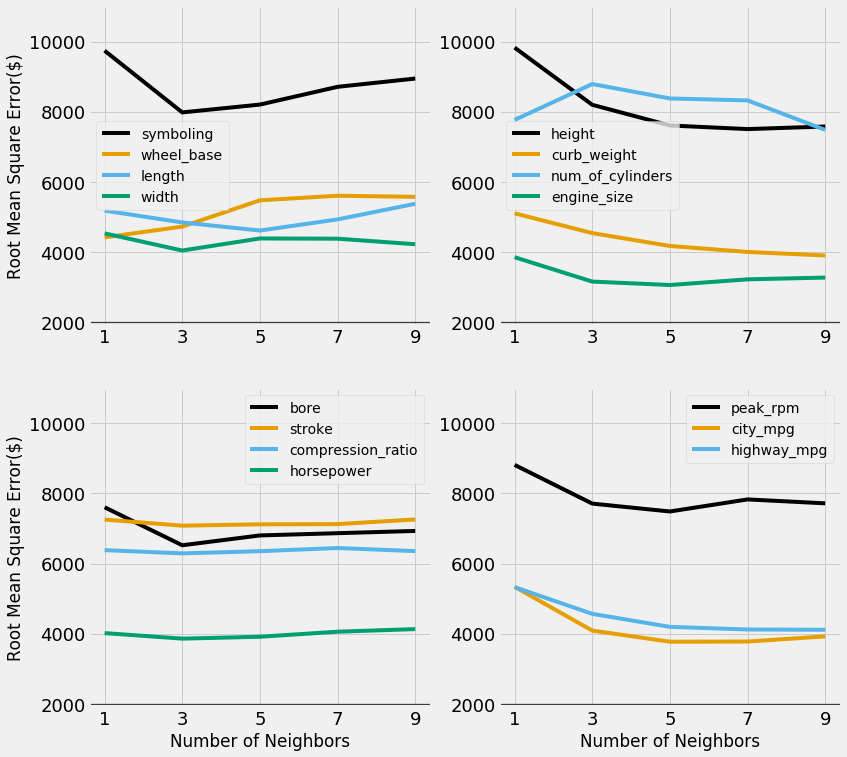

In [494]:
fig2 = plt.figure(figsize = (12, 12))

for i in range(4):
    if i != 3:
        ax = fig2.add_subplot(2,2,(i+1))
        knn_k_cv_plot = uni_knn_vs_k_cv_df.reset_index().plot(x = 'Number of Neighbors',
                                                              y = uni_features[(4*i):(4*i + 4)],
                                                              ax = ax, color = colors)
    else:
        ax = fig2.add_subplot(224)
        knn_k_cv_plot = uni_knn_vs_k_cv_df.reset_index().plot(x = 'Number of Neighbors',
                                                              y = uni_features[12:15], 
                                                              ax = ax, color = colors)
    
    knn_k_cv_plot.set_xticks([1, 3, 5, 7, 9])
    knn_k_cv_plot.axhline(2000, color = 'black', linewidth = 1.3, alpha = 0.7)
    knn_k_cv_plot.set_ylim([1930, 11000])
    knn_k_cv_plot.tick_params(labelsize = 18)
    
    if i == 0 or i == 1:
        knn_k_cv_plot.xaxis.label.set_visible(False)
    if i % 2 == 0:
        knn_k_cv_plot.set_ylabel('Root Mean Square Error($)')

The five features with the best performance are:
- engine_size
- city_mpg
- horsepower
- curb_weight
- width

These five features have demonstrated the best performance with 3 or 5 neighbors. This suggests that a car's performance, fuel efficiency, and size are what influence the determination of a car's value. We will now simultaneously test the k-nearest neighbors model's performance by increasing the complexity while varying the number of folds in the k-fold cross-validation process.

Text(2.5,3750,'Five Features')

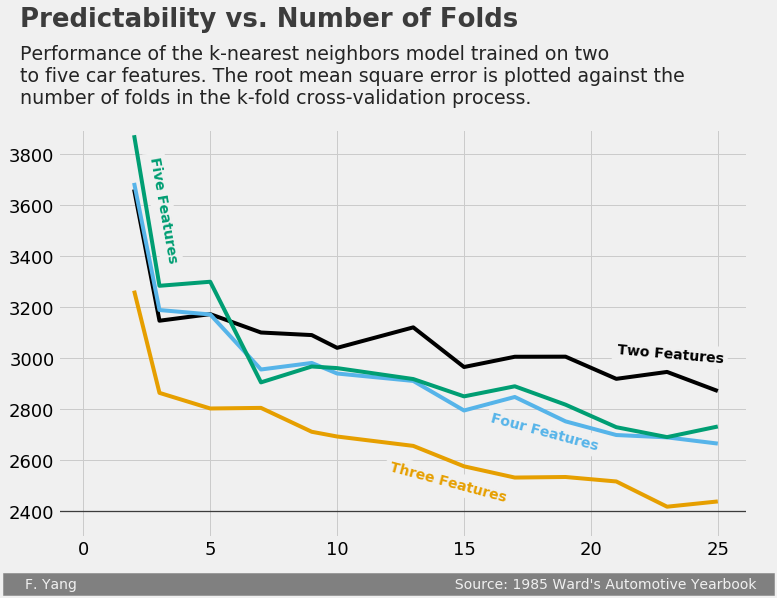

In [549]:
num_folds = [2, 3, 5, 7, 9, 10, 13, 15, 17, 19, 21, 23, 25]

# Store the RMSE of neighbors and fold test in a DataFrame
knn_feature_folds = pd.DataFrame([])
knn_feature_folds['Number of Folds'] = num_folds

rmse_two_features = []
rmse_three_features = []
rmse_four_features = []
rmse_five_features = []

for num in num_folds:
    # Two features
    rmse_two_features.append(knn_cross_validation(['engine_size', 'city_mpg'], 'price', normalized_cars, 5, num))
    # Three features
    rmse_three_features.append(knn_cross_validation(['engine_size', 'city_mpg', 'horsepower'], 
                                                    'price', normalized_cars, 5, num))
    # Four features
    rmse_four_features.append(knn_cross_validation(['engine_size', 'city_mpg', 'horsepower', 'curb_weight'], 
                                                   'price', normalized_cars, 5, num))
    # Five features
    rmse_five_features.append(knn_cross_validation(['engine_size', 'city_mpg', 'horsepower', 'curb_weight', 'width'],
                                                  'price', normalized_cars, 5, num))
    
# Store the lists in the DataFrame
knn_feature_folds['Two Features'] = rmse_two_features
knn_feature_folds['Three Features'] = rmse_three_features
knn_feature_folds['Four Features'] = rmse_four_features
knn_feature_folds['Five Features'] = rmse_five_features

feature_folds_plot = knn_feature_folds.plot(x = 'Number of Folds', y = knn_feature_folds.columns[1:],
                                            figsize = (11, 7), color = colors, legend = False)

feature_folds_plot.set_ylim([2300, 3900])
feature_folds_plot.set_xlim(xmin = -1)
feature_folds_plot.axhline(2400, color = 'black', linewidth = 1.3, alpha = 0.7)

feature_folds_plot.xaxis.label.set_visible(False)            # Remove x-axis label
feature_folds_plot.tick_params(axis = 'both', which = 'major', labelsize = 18)
#hvf_graph.set_xticks([1, 5, 10, 15, 20, 25])
#hvf_graph.set_xticklabels(labels = [1, 5, 10, 15, 20, 25])

# Add signature bar
feature_folds_plot.text(x = -3, y = 2100,
               s = "    F. Yang                                                                                    Source: 1985 Ward's Automotive Yearbook   ",
               fontsize = 14, 
               color = '#f0f0f0', backgroundcolor = 'grey')

# Add title and subtitle
feature_folds_plot.text(x = -2.5, y = 4300, s = 'Predictability vs. Number of Folds',
               fontsize = 26, weight = 'bold', alpha = .75)
feature_folds_plot.text(x = -2.5, y = 4000, s = 'Performance of the k-nearest neighbors model trained on two \nto five car features. The root mean square error is plotted against the\nnumber of folds in the k-fold cross-validation process.',
               fontsize = 19, alpha = .85)

# Add colored labels
feature_folds_plot.text(x = 21, y = 3020, s = 'Two Features', color = colors[0], weight = 'bold', rotation = -5,
               backgroundcolor = '#f0f0f0')
feature_folds_plot.text(x = 12, y = 2560, s = 'Three Features', color = colors[1], weight = 'bold', rotation = -15,
               backgroundcolor = '#f0f0f0')
feature_folds_plot.text(x = 16, y = 2750, s = 'Four Features', color = colors[2], weight = 'bold', rotation = -15,
               backgroundcolor = '#f0f0f0')
feature_folds_plot.text(x = 2.5, y = 3750, s = 'Five Features', color = colors[3], weight = 'bold', rotation = -80,
               backgroundcolor = '#f0f0f0')

We observe the best performance if three features are passed into a k-nearest neighbor model trained and tested with a 23-fold cross-validation technique. Let us measure the performance of the k-nearest neighbor model if we vary the number of features and hyperparameter with a 23-fold cross-validation technique.

In [552]:
# Vary the hyperparameter, the number of neighbors, from 1 to 25
hyperparam = range(1, 26)

# Store results in a DataFrame, which will be plotted
hyperparam_vs_features_cv = pd.DataFrame([])
hyperparam_vs_features_cv['Hyperparameter'] = hyperparam

two_feature_rmse_vs_k_cv = []
three_feature_rmse_vs_k_cv = []
four_feature_rmse_vs_k_cv = []
five_feature_rmse_vs_k_cv = []

for k in hyperparam:
    # Two features
    two_feature_rmse_vs_k_cv.append(knn_cross_validation(['engine_size', 'city_mpg'], 
                                                         'price', normalized_cars, k, 23))
    # Three features
    three_feature_rmse_vs_k_cv.append(knn_cross_validation(['engine_size', 'city_mpg', 'horsepower'], 
                                                          'price', normalized_cars, k, 23))
    # Four features
    four_feature_rmse_vs_k_cv.append(knn_cross_validation(['engine_size', 'city_mpg', 'horsepower', 'curb_weight'], 
                                                          'price', normalized_cars, k, 23))
    # Five features
    five_feature_rmse_vs_k_cv.append(knn_cross_validation(['engine_size', 'city_mpg', 'horsepower', 
                                                          'curb_weight', 'width'], 
                                                          'price', normalized_cars, k, 23))

hyperparam_vs_features_cv['Two Features'] = two_feature_rmse_vs_k_cv
hyperparam_vs_features_cv['Three Features'] = three_feature_rmse_vs_k_cv
hyperparam_vs_features_cv['Four Features'] = four_feature_rmse_vs_k_cv
hyperparam_vs_features_cv['Five Features'] = five_feature_rmse_vs_k_cv

print('The minimum RMSE for two features is', hyperparam_vs_features_cv['Two Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features_cv['Two Features'].values.argmin()])
print('The minimum RMSE for three features is', hyperparam_vs_features_cv['Three Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features_cv['Three Features'].values.argmin()])
print('The minimum RMSE for four features is', hyperparam_vs_features_cv['Four Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features_cv['Four Features'].values.argmin()])
print('The minimum RMSE for five features is', hyperparam_vs_features_cv['Five Features'].min(),
      'at k =', hyperparam[hyperparam_vs_features_cv['Five Features'].values.argmin()])

The minimum RMSE for two features is 2600.7034139465454 at k = 2
The minimum RMSE for three features is 2338.288127187341 at k = 2
The minimum RMSE for four features is 2236.3675194181155 at k = 2
The minimum RMSE for five features is 2292.6174873966897 at k = 1


Text(14.5,3450,'Five Features')

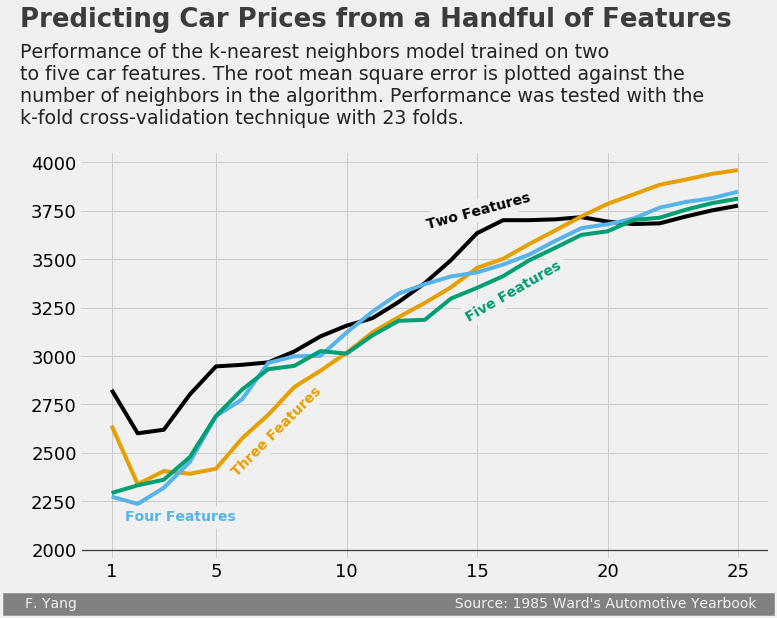

In [584]:
hvf_cv_graph = hyperparam_vs_features_cv.plot(x = 'Hyperparameter', y = hyperparam_vs_features_cv.columns[1:], 
                                              figsize = (11, 7), color = colors, legend = False)

hvf_cv_graph.axhline(2000, color = 'black', linewidth = 1.3, alpha = 0.7)
hvf_cv_graph.set_ylim(ymin = 1950)

hvf_cv_graph.xaxis.label.set_visible(False)            # Remove x-axis label
hvf_cv_graph.tick_params(axis = 'both', which = 'major', labelsize = 18)
hvf_cv_graph.set_xticks([1, 5, 10, 15, 20, 25])
hvf_cv_graph.set_xticklabels(labels = [1, 5, 10, 15, 20, 25])

# Add signature bar
hvf_cv_graph.text(x = -3, y = 1700,
                  s = "    F. Yang                                                                                    Source: 1985 Ward's Automotive Yearbook   ",
                  fontsize = 14, 
                  color = '#f0f0f0', backgroundcolor = 'grey')

# Add title and subtitle
hvf_cv_graph.text(x = -2.5, y = 4700, s = 'Predicting Car Prices from a Handful of Features',
               fontsize = 26, weight = 'bold', alpha = .75)
hvf_cv_graph.text(x = -2.5, y = 4200, s = 'Performance of the k-nearest neighbors model trained on two \nto five car features. The root mean square error is plotted against the\nnumber of neighbors in the algorithm. Performance was tested with the\nk-fold cross-validation technique with 23 folds.',
               fontsize = 19, alpha = .85)

# Add colored labels
hvf_cv_graph.text(x = 13, y = 3800, s = 'Two Features', color = colors[0], weight = 'bold', rotation = 15,
               backgroundcolor = '#f0f0f0')
hvf_cv_graph.text(x = 5.5, y = 2800, s = 'Three Features', color = colors[1], weight = 'bold', rotation = 45,
               backgroundcolor = '#f0f0f0')
hvf_cv_graph.text(x = 1.5, y = 2150, s = 'Four Features', color = colors[2], weight = 'bold', rotation = 0,
               backgroundcolor = '#f0f0f0')
hvf_cv_graph.text(x = 14.5, y = 3450, s = 'Five Features', color = colors[3], weight = 'bold', rotation = 30,
               backgroundcolor = '#f0f0f0')

When we train and test the k-nearest neighbors model with 23 partitions, we observe the best performance when we pass four features (engine_size, city_mpg, horsepower, curb_weight) into the model with two neighbors. The predicted car prices, then, are averages of the two most similar cars to the target car, and the features the model is trained on are all related to the performance of the car (engine characteristics, horsepower, and fuel effiency). 

# Conclusion

We performed the k-nearest neighbors regression algorithm to predict car prices based on the numerical features of cars in our dataset. We have observed the best performance when we pass features related to a car's performance (engine size, horsepower, fuel efficiency) into the k-nearest neighbors model. The model suggests that the most important factor in the evaluation of a car's price is the performance of the one or two most similar cars to our target car.

The errors in the k-fold cross-validation technique are not as small as the errors observed when we were using the train/test validation technique, but the k-fold cross-validation procedure had less biased training and test datasets.